In [2]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
batch_size = 16

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)


Files already downloaded and verified


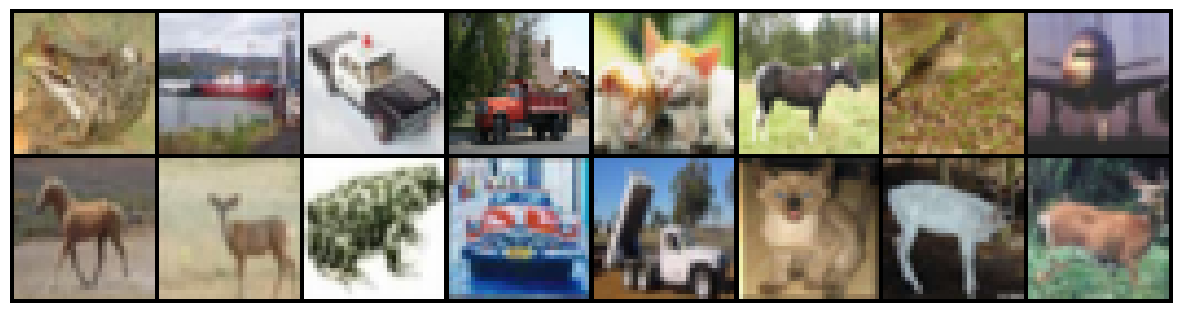

In [ ]:
for i, (imgs, labels) in enumerate(trainloader):
  images = imgs
  break

images = 0.5 * images + 0.5
grid_true = torchvision.utils.make_grid(images, nrow=8, padding=1, normalize=False)

plt.figure(figsize=(15, 15))
plt.imshow(np.transpose(grid_true, (1, 2, 0)))
plt.axis('off')
plt.show()

In [3]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_emb = nn.Embedding(10, 10)
        self.fc = nn.Sequential(
            nn.Linear(128 + 10, 256),
            nn.LeakyReLU(0.2)
        )
        self.conv_layers = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.ConvTranspose2d(32, 16, 4, 2, 1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),

            nn.ConvTranspose2d(16, 3, 4, 2, 1),
            nn.Tanh(),
        )

    def forward(self, z, labels):
        z = z.view(z.size(0), 128)
        c = self.label_emb(labels)
        # c = self.fc(c)
        x = torch.cat([z, c], 1)
        # print("G = ", x.shape)
        x = self.fc(x)
        x = x.view(-1, 256, 1, 1)
        return self.conv_layers(x)


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_emb = nn.Embedding(10, 10)
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, 4, 2, 1),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(16, 32, 4, 2, 1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(32, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, True)
            # nn.Sigmoid()


        )
        self.fc = nn.Sequential(
            nn.Linear(256 + 10, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1)
        # x = torch.transpose(x, 0, 1)
        # print(x.shape)
        return self.fc(x)


In [ ]:
G = Generator()
D = Discriminator()

criterion = nn.BCELoss()
optim_D = torch.optim.Adam(D.parameters(), lr=0.0002)
optim_G = torch.optim.Adam(G.parameters(), lr=0.0002)

In [ ]:
epochs = 50
latent_dim = 128

for epoch in range(epochs):

  for i, (imgs, labels) in enumerate(trainloader):

      batch_size = imgs.shape[0]
      # print(real_imgs.shape)
      true = torch.ones((batch_size, 1))
      fake = torch.zeros((batch_size, 1))

      G.zero_grad()

      z = torch.randn(batch_size, latent_dim)
      gen_labels = torch.LongTensor(np.random.randint(0, 10, batch_size))

      gen_imgs = G(z, gen_labels)
      # print("Gen imgs = ", gen_imgs.shape)
      # Loss measures generator's ability to fool discriminator
      validity = D(gen_imgs, gen_labels)
      g_loss = criterion(validity, true)

      g_loss.backward()
      optim_G.step()

      D.zero_grad()

      validity_real = D(imgs, labels)
      d_real_loss = criterion(validity_real, true)

      validity_fake = D(gen_imgs.detach(), gen_labels)
      d_fake_loss = criterion(validity_fake, fake)

      d_loss = d_real_loss + d_fake_loss

      d_loss.backward()
      optim_D.step()

  print("[Epoch %d/%d] [D loss: %f] [G loss: %f]" % (epoch, epochs, d_loss.item(), g_loss.item()))


[Epoch 0/50] [D loss: 0.164573] [G loss: 3.329196]
[Epoch 1/50] [D loss: 0.257483] [G loss: 2.547272]
[Epoch 2/50] [D loss: 0.163862] [G loss: 3.975039]
[Epoch 3/50] [D loss: 0.041636] [G loss: 6.801376]
[Epoch 4/50] [D loss: 0.552134] [G loss: 1.744323]
[Epoch 5/50] [D loss: 0.204911] [G loss: 2.848992]
[Epoch 6/50] [D loss: 0.045504] [G loss: 5.052713]
[Epoch 7/50] [D loss: 0.343392] [G loss: 4.544432]
[Epoch 8/50] [D loss: 0.920826] [G loss: 6.756310]
[Epoch 9/50] [D loss: 0.111562] [G loss: 3.586954]
[Epoch 10/50] [D loss: 0.776823] [G loss: 0.874999]
[Epoch 11/50] [D loss: 0.072719] [G loss: 5.472248]
[Epoch 12/50] [D loss: 1.599412] [G loss: 0.528974]
[Epoch 13/50] [D loss: 0.128046] [G loss: 3.700593]
[Epoch 14/50] [D loss: 1.521552] [G loss: 5.323337]
[Epoch 15/50] [D loss: 0.054636] [G loss: 5.556524]
[Epoch 16/50] [D loss: 0.105962] [G loss: 4.669725]
[Epoch 17/50] [D loss: 0.344883] [G loss: 4.368725]
[Epoch 18/50] [D loss: 0.055671] [G loss: 3.954777]
[Epoch 19/50] [D loss:

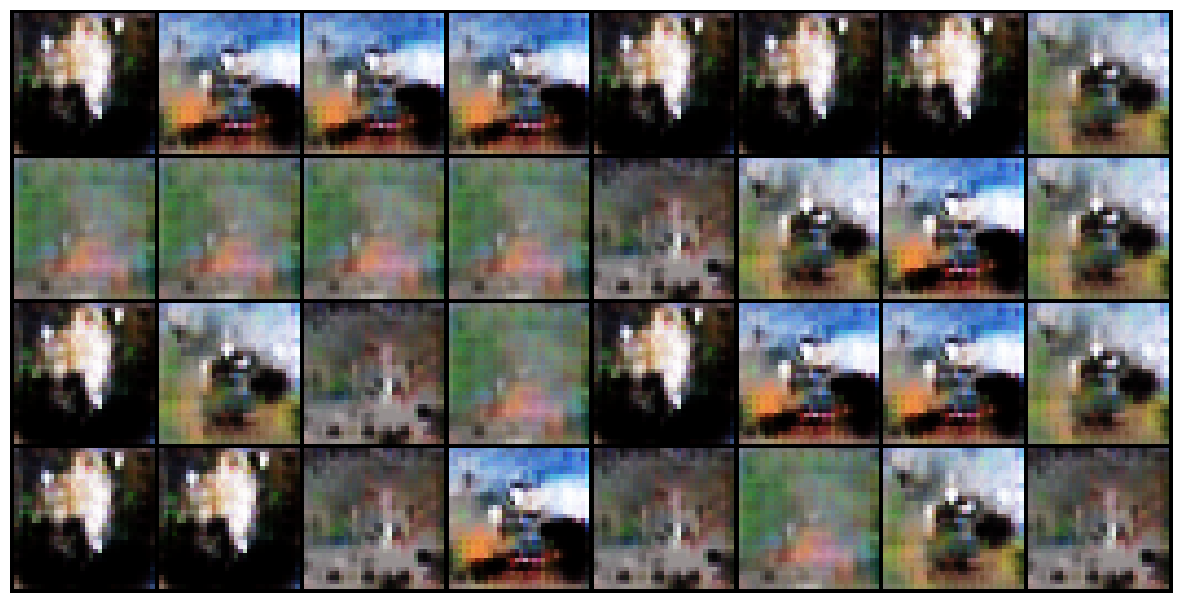

In [ ]:
G.eval()

noise = torch.randn(32, latent_dim)
random_labels = torch.LongTensor([np.random.randint(0, 5) for _ in range(32)])

with torch.no_grad():
    generated_images = G(noise, random_labels).detach().cpu()

generated_images = 0.5 * generated_images + 0.5

grid = torchvision.utils.make_grid(generated_images, nrow=8, padding=1, normalize=False)

plt.figure(figsize=(15, 15))
plt.imshow(np.transpose(grid, (1, 2, 0)))
plt.axis('off')
plt.show()

In [ ]:
torch.save(G.state_dict(), 'Generator.pth')

In [ ]:
torch.save(D.state_dict(), 'Discriminator.pth')

0 = automobile
1 = airplane
2 = airplane
3 = airplane
4 = automobile
5 = automobile
6 = automobile
7 = cat
8 = bird
9 = bird
10 = bird
11 = bird
12 = deer
13 = cat
14 = airplane
15 = cat
16 = automobile
17 = cat
18 = deer
19 = bird
20 = automobile
21 = airplane
22 = airplane
23 = cat
24 = automobile
25 = automobile
26 = deer
27 = airplane
28 = deer
29 = bird
30 = cat
31 = deer


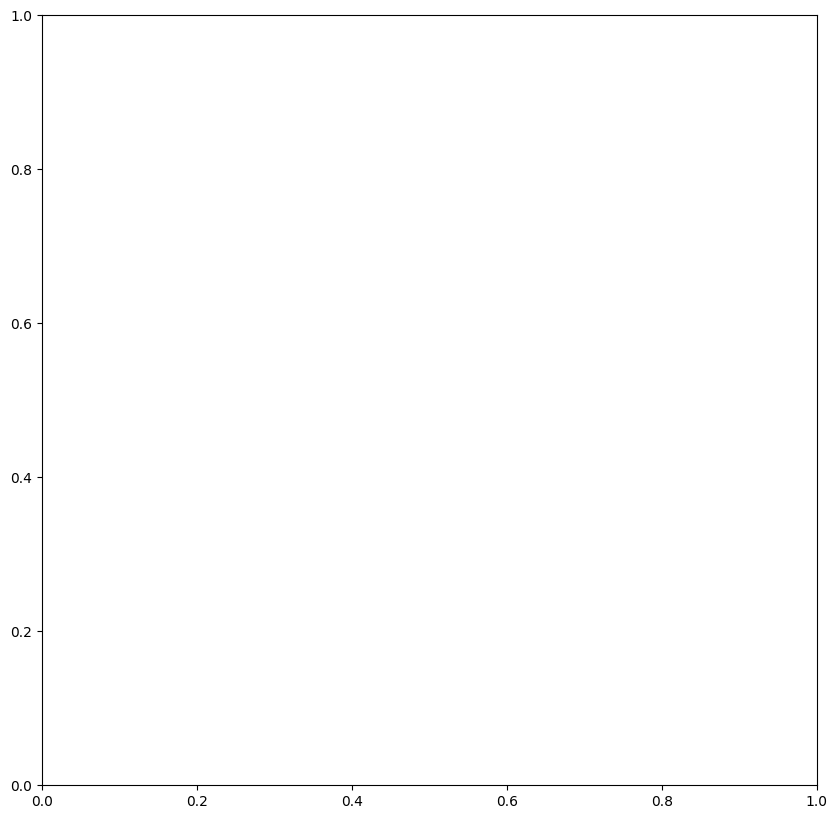

In [ ]:

class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

for i in range(32):
    image_label = class_labels[random_labels[i]]

    print(str(i) + " = " + str(image_label))

In [ ]:
from google.colab import widgets
grid = widgets.Grid(4,8)
j=0
for i in range(32):
  with grid.output_to(i//8, i%8):
    image_label = class_labels[random_labels[i]]
    print(image_label)



,,,,,,,
,,,,,,,
,,,,,,,
,,,,,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

automobile


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

airplane


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

airplane


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

airplane


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

automobile


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

automobile


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

automobile


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

cat


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

bird


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

bird


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

bird


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

bird


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

deer


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

cat


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

airplane


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

cat


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

automobile


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

cat


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

deer


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

bird


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

automobile


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

airplane


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

airplane


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

cat


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

automobile


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

automobile


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

deer


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

airplane


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

deer


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

bird


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

cat


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

deer


<IPython.core.display.Javascript object>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
res_folder = "/content/drive/MyDrive/Colab Projects/DL/cfg_res"
dataset_folder = "/content/drive/MyDrive/Colab Projects/DL/train"
check_point_dir = "/content/drive/MyDrive/Colab Projects/DL/cfg_res"

In [4]:
import os
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
def inverse_transform(tensors):
    return (((tensors.clamp(-1, 1) + 1.0) / 2.0) * 255.0).type(torch.uint8)

In [7]:
class DiffusionHelper:
    def __init__(self,
                 inverse_transform,
                 noise_steps = 1000,
                 beta_start = 0.0001,
                 beta_end = 0.02,
                 img_size = 64,
                 device = "cuda",
                 ):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.device = device
        self.inverse_transform = inverse_transform

        self.beta = torch.linspace(self.beta_start, self.beta_end, self.noise_steps).to(device)
        self.alpha = 1 - self.beta

        self.alpha_hat = torch.cumprod(self.alpha, dim=0)


    def add_noise(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1-self.alpha_hat[t])[:, None, None, None]
        eps = torch.randn_like(x)
        return sqrt_alpha_hat*x + sqrt_one_minus_alpha_hat*eps, eps


    def reverse_diffuse(self, model, batch_size, labels, guidance_strength):
        model.eval()
        with torch.no_grad():
            x = torch.randn((batch_size, 3, self.img_size, self.img_size)).to(self.device)
            for timestep in reversed(range(1, self.noise_steps)):
                t = (torch.ones(batch_size) * timestep).long().to(self.device)

                predicted_noise = model(x, t, labels)
                unconditioned_pred_noise = model(x, t, None)

                predicted_noise = torch.lerp(predicted_noise, unconditioned_pred_noise, guidance_strength)

                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                noise = torch.randn_like(x) if timestep > 1 else torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        model.train()

        return self.inverse_transform(x)

In [8]:
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms
from torchvision.datasets import ImageFolder

transforms = torchvision.transforms.Compose(
        [
            torchvision.transforms.Resize((32, 32)),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Lambda(lambda t: (t * 2) - 1)
        ]
    )


# dataset = datasets.CIFAR10(root="data", train=True, download=True, transform=transforms)
dataset = ImageFolder(dataset_folder, transform=transforms)

In [9]:
dataloader = DataLoader(dataset, batch_size=16,
                            shuffle=True)
vis_loader = DataLoader(dataset, batch_size=6,
                            shuffle=True)

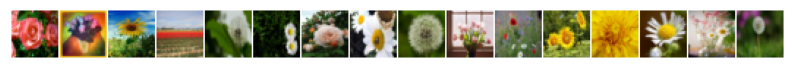

In [10]:
from torchvision.utils import make_grid

plt.figure(figsize=(10, 4), facecolor='white')

for b_image, _ in dataloader:
    b_image = inverse_transform(b_image)
    grid_img = make_grid(b_image / 255.0, nrow=16, padding=True, pad_value=1)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis("off")
    break

In [11]:
diffusion_helper = DiffusionHelper(inverse_transform=inverse_transform, img_size=32, device=device)

In [12]:
noisy_images = []
specific_timesteps = [0, 10, 50, 100, 150, 200, 250, 300, 400, 600, 800, 999]

images, labels = next(iter(vis_loader))

for timestep in specific_timesteps:
    timestep = torch.as_tensor([[[timestep]]], dtype=torch.long)

    xts, _ = diffusion_helper.add_noise(images.to(device), timestep)
    xts = inverse_transform(xts[:, None, None, None])

    noisy_images.append(xts)

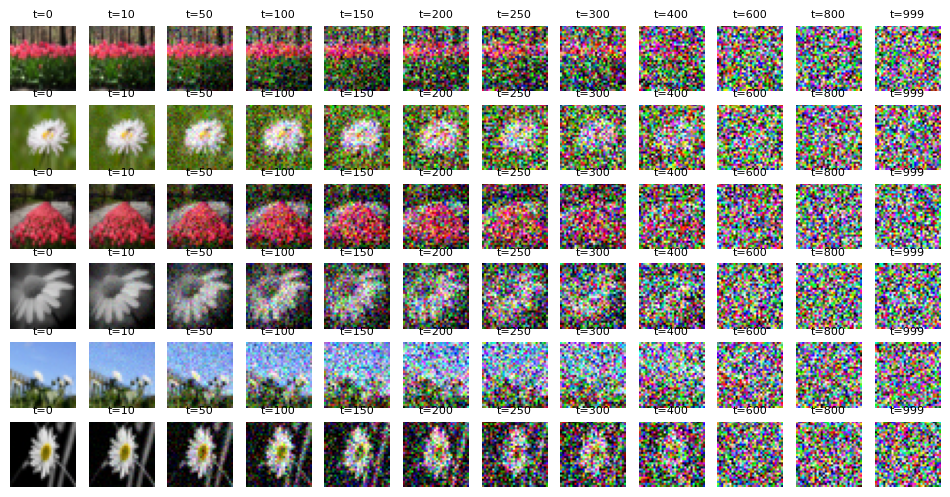

In [13]:
_, ax = plt.subplots(6, len(noisy_images), figsize=(12, 6))

for j, (timestep, noisy_sample) in enumerate(zip(specific_timesteps, noisy_images)):
    noisy_sample = torch.squeeze(noisy_sample, dim=(0, 1, 2, 3, 4))
    for i in range(len(noisy_sample)):
        ax[i][j].imshow((noisy_sample[i].permute(1, 2, 0)/255.0).cpu())
        ax[i][j].set_title(f"t={timestep}", fontsize=8)
        ax[i][j].axis("off")
        ax[i][j].grid(False)

plt.axis("off")
plt.show()

In [14]:
NUM_CLASSES = len(np.unique(dataloader.dataset.targets))

In [15]:
class SelfAttention(nn.Module):
    def __init__(self, channels, size):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        x = x.view(-1, self.channels, self.size * self.size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, self.size, self.size)



In [16]:
class ResidualDoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels):
        super(ResidualDoubleConv, self).__init__()

        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        return nn.GELU()(x + self.double_conv(x))

In [17]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels):
        super(DoubleConv, self).__init__()

        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
       return self.double_conv(x)

In [18]:
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            ResidualDoubleConv(in_channels, in_channels, in_channels),
            DoubleConv(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


In [19]:
class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            ResidualDoubleConv(in_channels, in_channels, in_channels),
            DoubleConv(in_channels, out_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, t):
        x = self.maxpool_conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


In [20]:
class UNetEncoder(nn.Module):
    def __init__(self):
        super(UNetEncoder, self).__init__()

        self.down1 = Down(64, 128)
        self.sa1 = SelfAttention(128, 16)
        self.down2 = Down(128, 128)
        self.sa2 = SelfAttention(128, 8)


    def forward(self, x, t):

        x2 = self.down1(x, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)

        return x2, x3

In [21]:
class UNetBottleneck(nn.Module):
    def __init__(self):
        super(UNetBottleneck, self).__init__()
        self.bot1 = DoubleConv(128, 256, 256)
        self.bot2 = DoubleConv(256, 256, 256)
        self.bot3 = DoubleConv(256, 128, 128)

    def forward(self, x):
        x = self.bot1(x)
        x = self.bot2(x)
        x = self.bot3(x)
        return x

In [22]:
class UNetDecoder(nn.Module):
    def __init__(self):
        super(UNetDecoder, self).__init__()
        self.up1 = Up(256, 64)
        self.sa3 = SelfAttention(64, 16)
        self.up2 = Up(128, 32)
        self.sa4 = SelfAttention(32, 32)

    def forward(self, x1, x2, x3, t):
        x = self.up1(x3, x2, t)
        x = self.sa3(x)
        x = self.up2(x, x1, t)
        x = self.sa4(x)
        return x

In [23]:
class UNet(nn.Module):
    def __init__(self, c_in=3, c_out=3, time_dim=256, num_classes = None, device="cuda"):
        super().__init__()
        self.device = device
        self.time_dim = time_dim

        self.inc = DoubleConv(c_in, 64, 64)

        self.encoder = UNetEncoder()
        self.bottleneck = UNetBottleneck()
        self.decoder = UNetDecoder()

        self.outc = nn.Conv2d(32, c_out, kernel_size=1)

        if num_classes:
            self.label_emb = nn.Embedding(num_classes, time_dim)

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, t, y):
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)

        if y is not None:
            t += self.label_emb(y)

        x1 = self.inc(x)

        x2, x3 = self.encoder(x1, t)
        x3 = self.bottleneck(x3)
        x = self.decoder(x1, x2, x3, t)

        output = self.outc(x)
        return output

In [24]:
model = UNet(3, 3, num_classes=NUM_CLASSES).to(device)

In [29]:
from PIL import Image

def save_images(images, path, **kwargs):
  grid = torchvision.utils.make_grid(images, **kwargs)
  ndarr = grid.permute(1, 2, 0).to('cpu').numpy()
  im = Image.fromarray(ndarr)
  im.save(path)

In [25]:
EPOCHS = 500
criterion = nn.MSELoss()
optim = torch.optim.Adam(model.parameters(), lr=2e-4)

loss_list = []

for epoch in range(EPOCHS):
    batch = 1
    for x0s, labels in dataloader:
        ts = torch.randint(low=1, high=1000, size=(x0s.shape[0],), device=device)

        xts, added_noise = diffusion_helper.add_noise(x0s.to(device), ts)

        labels = labels.to(device)

        if torch.rand(1) < 0.1:
           labels = None

        pred_noise = model(xts, ts, labels)

        loss = criterion(added_noise, pred_noise)

        optim.zero_grad()
        loss.backward()
        optim.step()

        # if batch % 100 == 0:
        #   print(f"Epoch {epoch+1}, Batch {batch}/{len(dataloader)}")

        batch += 1

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")
    loss_list.append(round(loss.item(), 5))

    if (epoch+1) % 50 == 0:
      samp_images = diffusion_helper.reverse_diffuse(model, x0s.shape[0], labels, 3)
      save_images(samp_images, os.path.join(res_folder, f"{epoch+1}.png"))
      torch.save(model.state_dict(), os.path.join(check_point_dir,f"{epoch+1}_ckpt.pt"))


print("Training done")

Epoch 1, Loss: 0.1499
Epoch 2, Loss: 0.0868
Epoch 3, Loss: 0.0423
Epoch 4, Loss: 0.0615
Epoch 5, Loss: 0.0643
Epoch 6, Loss: 0.1839
Epoch 7, Loss: 0.0265
Epoch 8, Loss: 0.1686
Epoch 9, Loss: 0.0617
Epoch 10, Loss: 0.0228
Epoch 11, Loss: 0.0219
Epoch 12, Loss: 0.0893
Epoch 13, Loss: 0.0267
Epoch 14, Loss: 0.0199
Epoch 15, Loss: 0.0197
Epoch 16, Loss: 0.0185
Epoch 17, Loss: 0.0572
Epoch 18, Loss: 0.0660
Epoch 19, Loss: 0.0382
Epoch 20, Loss: 0.0292
Epoch 21, Loss: 0.0392
Epoch 22, Loss: 0.0391
Epoch 23, Loss: 0.1008
Epoch 24, Loss: 0.0960
Epoch 25, Loss: 0.0397
Epoch 26, Loss: 0.0407
Epoch 27, Loss: 0.0688
Epoch 28, Loss: 0.0202
Epoch 29, Loss: 0.1521
Epoch 30, Loss: 0.0182
Epoch 31, Loss: 0.0936
Epoch 32, Loss: 0.0445
Epoch 33, Loss: 0.0141
Epoch 34, Loss: 0.0183
Epoch 35, Loss: 0.0208
Epoch 36, Loss: 0.0637
Epoch 37, Loss: 0.0480
Epoch 38, Loss: 0.0429
Epoch 39, Loss: 0.0105
Epoch 40, Loss: 0.0794
Epoch 41, Loss: 0.0553
Epoch 42, Loss: 0.0376
Epoch 43, Loss: 0.0370
Epoch 44, Loss: 0.01

TypeError: ignored

In [30]:
model.load_state_dict(torch.load(os.path.join(check_point_dir,"500_ckpt.pt")))

<All keys matched successfully>

In [31]:
label_i = [0, 1, 2, 3, 4]
labels_list = ["Daisy", "Dandelion", "Rose", "Sunflower", "Tulip"]

In [33]:
SAMPLE_COUNT = 16

for lb_i in label_i:
  current_count = 0
  lbl_images = []
  for images, labels in dataloader:
    if len(lbl_images) == SAMPLE_COUNT:
      break
    for idx, lbl in enumerate(labels):
      if lbl.item() == lb_i:
        if len(lbl_images) == SAMPLE_COUNT:
          break
        lbl_images.append(inverse_transform(images[idx]))

  save_images(lbl_images, os.path.join(res_folder, f"{lb_i}_{labels_list[lb_i]}_images.png"))
  samp_images = diffusion_helper.reverse_diffuse(model, SAMPLE_COUNT, torch.full((SAMPLE_COUNT,), lb_i, device=device).long(), 3)
  save_images(samp_images, os.path.join(res_folder, f"{labels_list[lb_i]}_final_results.png"))

In [34]:
samp_images = diffusion_helper.reverse_diffuse(model, SAMPLE_COUNT, None, 3)
save_images(samp_images, os.path.join(res_folder, f"all_samp_final_results.png"))